### TODO:

- [ ] make this into a script
- [ ] don't use a new `lm` plot function

In [11]:
import logging
import warnings
from os.path import join

import matplotlib
import matplotlib.pyplot as plt
import myfuncs as my
import numpy as np
import pandas as pd
import pymc3 as pm

matplotlib = my.utilities.set_mpl_defaults(matplotlib)

warnings.filterwarnings("ignore")

logger = logging.getLogger("pymc3")
logger.setLevel(logging.ERROR)

RESULTS_DIR = join("..", "results")
OUTPUT_DIR = join("..", "figures")

sample_kwargs = {"cores": 1, "random_seed": 4, "progressbar": False}

from string import ascii_lowercase

import arviz as az

In [12]:
# Read estimates file
recovery_results = pd.read_csv(
    join("..", "results", "S_recoveries", "estimates", "estimates_de1.csv")
)

In [13]:
recovery_results = recovery_results.rename({"model": "model_rec"}, axis=1)
# Recover generating model
recovery_results["model_gen"] = (
    recovery_results["subject"].str.split("-").str[1:].str.join("-")
)

# Parameter recovery

In [14]:
parameters = {
    "eu": ["alpha", "beta"],
    "pt": ["alpha", "gamma", "beta"],
    "gaze-baseline-dyn": ["lam", "beta"],
    "gaze-baseline-stat": ["beta"],
    "glickman1layer": ["alpha", "gamma", "theta", "lam", "beta"],
    "mdft": ["w", "wd", "phi1", "phi2", "sig2"],
}

limits = dict(
    alpha=[0, 2],
    beta=[0, 50],
    gamma=[0, 1],
    lam=[0, 1],
    theta=[0, 1],
    w=[0, 1],
    wd=[1, 50],
    phi1=[0, 1000],
    phi2=[0, 1],
    sig2=[0, 1000],
)

labels = dict(
    alpha=r"$\alpha$",
    beta=r"$\beta$",
    gamma=r"$\gamma$",
    lam=r"$\lambda$",
    theta=r"$\theta$",
    w=r"$w_p$",
    wd=r"$wd$",
    phi1=r"$\varphi_1$",
    phi2=r"$\varphi_2$",
    sig2=r"$\sigma_2$",
)

# Colours to use
palette = [
    "slategray",
    "darksalmon",
    "mediumaquamarine",
    "indianred",
    "paleturquoise",
    "lightpink",
    "tan",
    "orchid",
]

# Model labels to use in the figures
models = np.array(
    ["glickman1layer", "mdft", "eu", "pt", "gaze-baseline-stat", "gaze-baseline-dyn"]
)

models_no_eu = [model for model in models if model != "eu"]

model_labels = {
    "glickman1layer": "GLA",
    "mdft": "MDFT",
    "eu": "EU",
    "pt": "PT",
    "gaze-baseline-stat": "GB$_{stat}$",
    "gaze-baseline-dyn": "GB$_{dyn}$",
}

glickman1layer
alpha
gamma
theta
lam
beta
mdft
w
wd
phi1
phi2
sig2
pt
alpha
gamma
beta
gaze-baseline-stat
beta
gaze-baseline-dyn
lam


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


beta


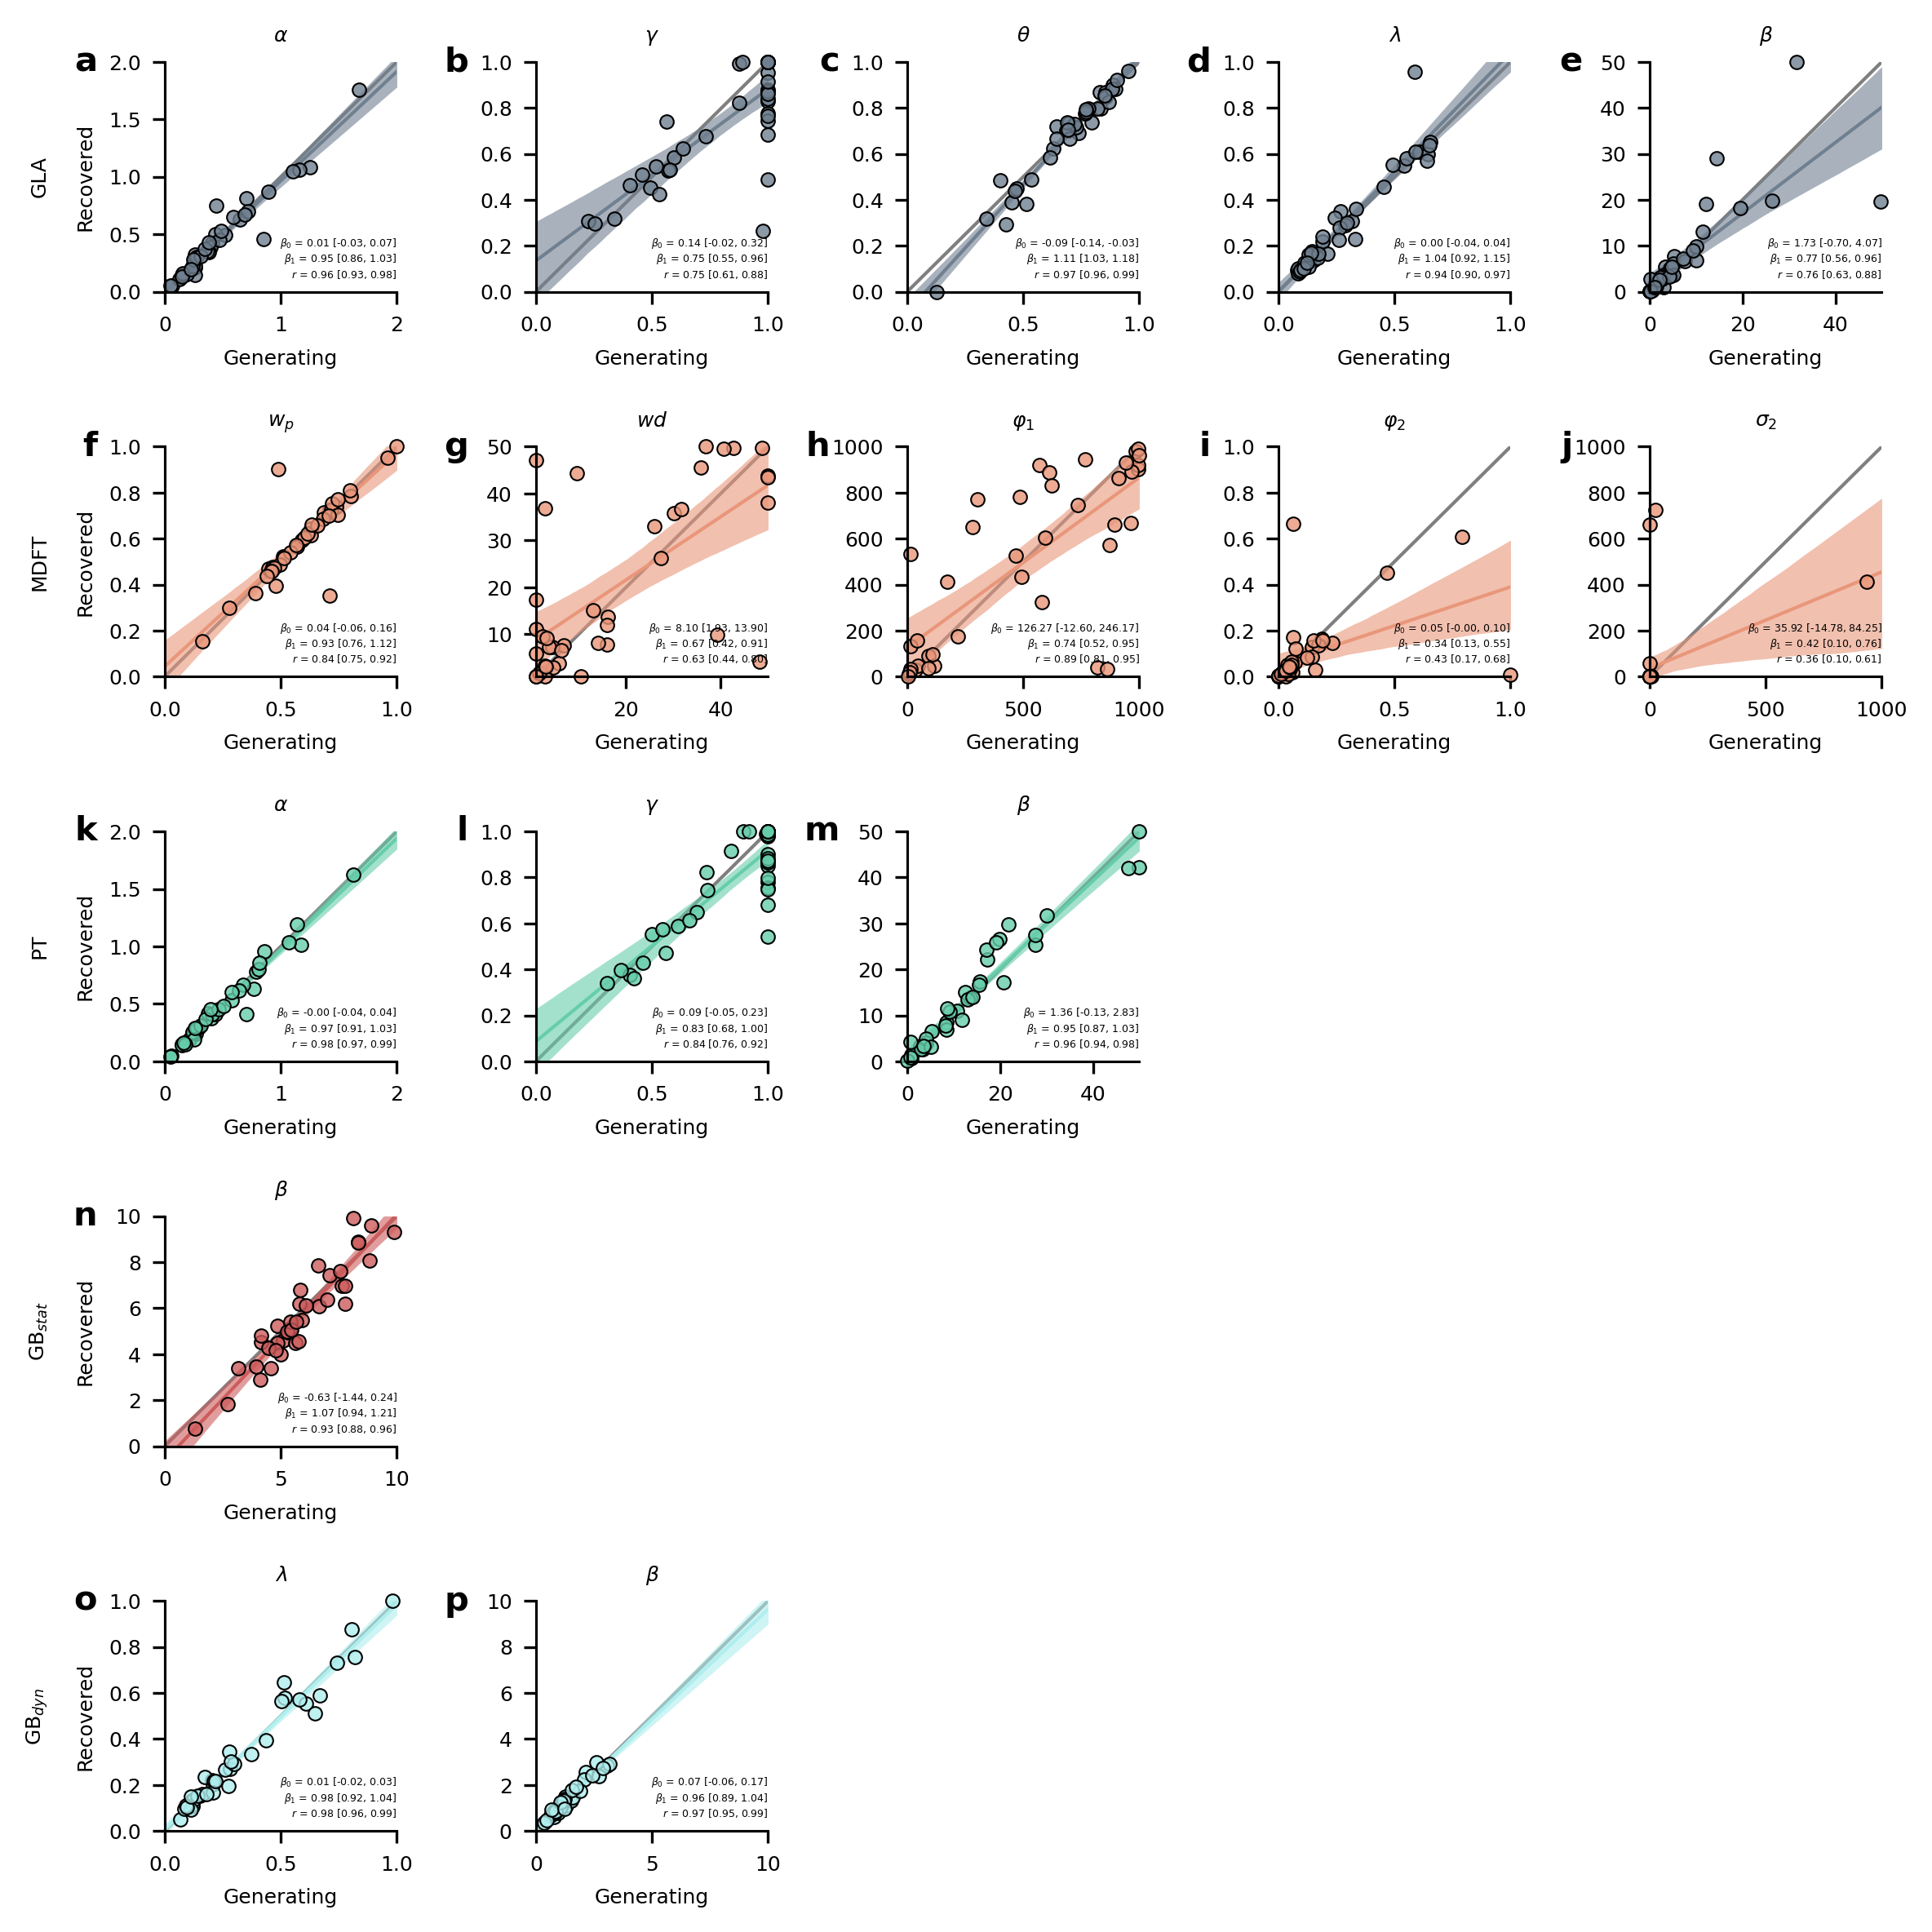

In [20]:
# Combined figure
panel_width = 4
panel_height = 4

n_parameters_max = 5
n_models = len(models_no_eu)
fig, axs = plt.subplots(
    n_models,
    n_parameters_max,
    figsize=my.utilities.cm2inch(
        panel_width * n_parameters_max, panel_height * n_models
    ),
    dpi=300,
)

all_axs = []
for m, model in enumerate(models_no_eu):
    print(model)
    recovery_m = recovery_results.loc[
        (recovery_results["model_gen"] == model)
        & (recovery_results["model_rec"] == model)
    ]
    n_parameters = len(parameters[model])

    axs_m = axs[m, :]

    for p, parameter in enumerate(parameters[model]):
        print(parameter)
        gen = recovery_m[parameter + "_gen"]
        rec = recovery_m[parameter]
        axs_m[p], glm_data, corr_data = my.plots.lm(
            x=gen,
            y=rec,
            sample_kwargs=sample_kwargs,
            ax=axs_m[p],
            scatter_color=palette[m],
            scatter_kws=dict(clip_on=False),
            line_color=palette[m],
            xrange=limits[parameter],
            stats_annotation=False,
        )

        # Add stats annotation
        # Determine HDI column names in az.summary, based on hdi_prob
        hdi_prob = 0.95
        summary_corr = az.summary(corr_data, hdi_prob=hdi_prob)
        summary_glm = az.summary(glm_data, hdi_prob=hdi_prob)

        if ((100 * hdi_prob) % 2) == 0:
            digits = 0
        else:
            digits = 1
        hdi_lower = f"hdi_{100 * (1 - hdi_prob) / 2:.{digits}f}%"
        hdi_upper = f"hdi_{100 * (1 - (1 - hdi_prob) / 2):.{digits}f}%"

        stat_str = (
            r"$\beta_0$"
            + f" = {summary_glm.loc['Intercept', 'mean']:.2f} [{summary_glm.loc['Intercept', hdi_lower]:.2f}, {summary_glm.loc['Intercept', hdi_upper]:.2f}]"
            + "\n"
            + r"$\beta_1$"
            + f" = {summary_glm.loc['x', 'mean']:.2f} [{summary_glm.loc['x', hdi_lower]:.2f}, {summary_glm.loc['x', hdi_upper]:.2f}]"
        )
        stat_str_corr = (
            r"$r$"
            + f" = {summary_corr.loc['r', 'mean']:.2f} [{summary_corr.loc['r', hdi_lower]:.2f}, {summary_corr.loc['r', hdi_upper]:.2f}]"
        )

        axs_m[p].annotate(
            stat_str + "\n" + stat_str_corr,
            [1, 0.05],
            xycoords="axes fraction",
            ma="right",
            ha="right",
            va="bottom",
            fontsize=3,
        )

        axs_m[p].set_title(labels[parameter])
        axs_m[p].set_xlabel("Generating")
        if (parameter == "beta") and (
            model in ["gaze-baseline-dyn", "gaze-baseline-stat"]
        ):
            axs_m[p].set_xlim(0, 10)
            axs_m[p].set_ylim(0, 10)
        else:
            axs_m[p].set_xlim(*limits[parameter])
            axs_m[p].set_ylim(*limits[parameter])
        axs_m[p].plot(
            limits[parameter], limits[parameter], color="k", alpha=0.5, zorder=-1
        )
        if p == 0:
            axs_m[p].set_ylabel(f"{model_labels[model]}\n\nRecovered")

        all_axs.append(axs_m[p])

    # disable unused axes
    for unused in range(p + 1, n_parameters_max):
        axs_m[unused].axis("off")

plt.tight_layout(h_pad=2, w_pad=2)
fig.align_ylabels(axs[:, 0])


for ax, label in zip(all_axs, list(ascii_lowercase)):
    # Place axis labels in figure space, so that they are aligned
    # https://stackoverflow.com/a/52309638
    if label in ["h", "j"]:
        xshift = 0.04
    else:
        xshift = 0.035
    X = ax.get_position().x0
    Y = ax.get_position().y1
    fig.text(X - xshift, Y, label, size=10, weight="bold", ha="right", va="center")

plt.savefig(join("..", "figures", f"S_parameter-recovery_all.pdf"), bbox_inches="tight")
plt.show()

# Model recovery

For model recovery, we need to perform one Bayesian Model Selection (BMS) analysis for each generating model.

## Including EU

In [16]:
bms_results = {}
xp = np.zeros((len(models), len(models))) * np.nan
mpp = np.zeros_like(xp) * np.nan

# for each generating model:
for m, model in enumerate(models):
    bics = (
        recovery_results.loc[recovery_results["model_gen"] == model][
            ["subject", "model_gen", "model_rec", "bic"]
        ]
        .pivot_table(values="bic", columns="model_rec", index="subject")[models]
        .T.values
    )
    L = -0.5 * bics

    bms_results[model] = my.stats.bms(L, cores=1)
    xp[m, :] = bms_results[model]["xp"]
    mpp[m, :] = bms_results[model]["r"]

INFO (theano.gof.compilelock): Refreshing lock /Users/moltaire/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.6-64/lock_dir/lock


INFO (theano.gof.compilelock): Refreshing lock /Users/moltaire/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.6-64/lock_dir/lock
There were 387 divergences after tuning. Increase `target_accept` or reparameterize.
There were 579 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


INFO (theano.gof.compilelock): Refreshing lock /Users/moltaire/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.6-64/lock_dir/lock
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


INFO (theano.gof.compilelock): Refreshing lock /Users/moltaire/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.6-64/lock_dir/lock
There were 451 divergences after tuning. Increase `target_accept` or reparameterize.
There were 471 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


INFO (theano.gof.compilelock): Refreshing lock /Users/moltaire/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.6-64/lock_dir/lock
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 841 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


There were 479 divergences after tuning. Increase `target_accept` or reparameterize.
There were 733 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


INFO (theano.gof.compilelock): Refreshing lock /Users/moltaire/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.8.6-64/lock_dir/lock
There were 798 divergences after tuning. Increase `target_accept` or reparameterize.
There were 812 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


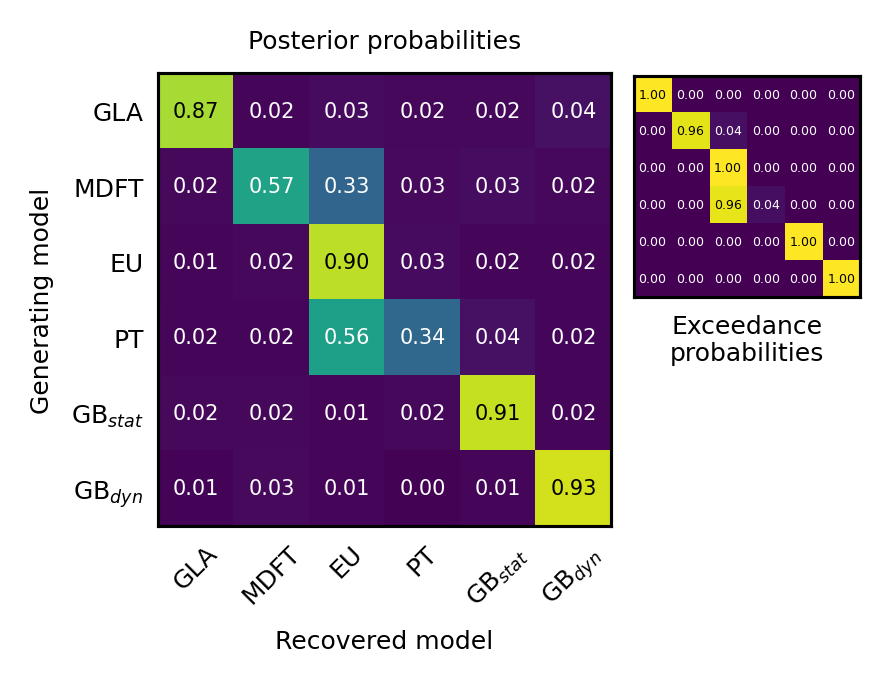

In [17]:
# Plot
ax = my.plots.model_recovery(
    mpp=mpp,
    xp=xp,
    model_labels=[model_labels[model] for model in models],
    inset_aspect=0.75,
)
plt.savefig(join("..", "figures", "S_model-recovery.pdf"), dpi=300, bbox_inches="tight")

## Excluding EU

In [18]:
bms_results_no_eu = {}
xp_no_eu = np.zeros((len(models_no_eu), len(models_no_eu))) * np.nan
mpp_no_eu = np.zeros_like(xp) * np.nan

# for each generating model:
for m, model in enumerate(models_no_eu):
    bics = (
        recovery_results.loc[recovery_results["model_gen"] == model][
            ["subject", "model_gen", "model_rec", "bic"]
        ]
        .pivot_table(values="bic", columns="model_rec", index="subject")[models_no_eu]
        .T.values
    )
    L = -0.5 * bics

    bms_results_no_eu[model] = my.stats.bms(L, cores=1)
    xp_no_eu[m, :] = bms_results_no_eu[model]["xp"]
    mpp_no_eu[m, :] = bms_results_no_eu[model]["r"]

There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


ValueError: could not broadcast input array from shape (5) into shape (6)

In [ ]:
# Plot
ax = my.plots.model_recovery(
    mpp=mpp_no_eu,
    xp=xp_no_eu,
    model_labels=[model_labels[model] for model in models_no_eu],
    inset_aspect=0.75,
)
plt.savefig(
    join("..", "figures", "S_model-recovery_without-eu.pdf"),
    dpi=300,
    bbox_inches="tight",
)